## Display the xml element tree

In [1]:
from pptlayout.extractors.run_extractors import run_extractors
from json import dumps
# Replace with your actual PPTX file path
pptx_path = "/data/tianyuhu/PPTLayout/data/pptx/ZK7FNUZ33GBBCG7CFVYS56TQCTD72CJR.pptx"

# Run extractors
info = run_extractors(pptx_path, "emu")
print(dumps(info, indent=4))

{
    "slide_width": 9144000,
    "slide_height": 6858000,
    "slides": [
        {
            "slide_id": 256,
            "slide_name": "",
            "shapes": [
                {
                    "name": "PlaceHolder 1",
                    "shape_id": 22,
                    "shape_type": "PLACEHOLDER",
                    "measurement_unit": "emu",
                    "height": 2228760,
                    "width": 7772400,
                    "left": 685800,
                    "top": 1371240,
                    "text": "Design for a 2 MW graphite target\u000b\u000bfor a neutrino beam",
                    "placeholder_type": "TITLE"
                },
                {
                    "name": "PlaceHolder 2",
                    "shape_id": 23,
                    "shape_type": "PLACEHOLDER",
                    "measurement_unit": "emu",
                    "height": 1752480,
                    "width": 8153640,
                    "left": 380520,
                 

In [2]:
from pptlayout.llm.call_ollama import generate_slide_layout_suggestions
from pptlayout.llm.prompts import build_slide_layout_suggestion_prompts

# Call OLLAMA
slide_info = info["slides"][0]
prompt = build_slide_layout_suggestion_prompts(
    json_input=slide_info, 
    slide_width=info["slide_width"],
    slide_height=info["slide_height"]
    )
suggestions = generate_slide_layout_suggestions(
    model_name="llama3.1:70b",
    prompt=prompt,
    temperature=0.5,
    )
print(suggestions)

Based on the provided JSON input, I analyzed the layout and suggest an improved version to enhance readability, visual appeal, and overall coherence. Here is the revised JSON output:

```json
{
  "slide_id": 256,
  "slide_name": "",
  "shapes": [
    {
      "name": "PlaceHolder 1",
      "shape_id": 22,
      "shape_type": "PLACEHOLDER",
      "measurement_unit": "emu",
      "height": 2000000,
      "width": 7000000,
      "left": 850000,
      "top": 1200000,
      "text": "Design for a 2 MW graphite target\x0b\x0bfor a neutrino beam",
      "placeholder_type": "TITLE"
    },
    {
      "name": "PlaceHolder 2",
      "shape_id": 23,
      "shape_type": "PLACEHOLDER",
      "measurement_unit": "emu",
      "height": 1500000,
      "width": 7500000,
      "left": 500000,
      "top": 4200000,
      "text": "Jim Hylen\n\nAccelerator Physics and Technology Workshop for Project X\x0bNovember 12-13, 2007",
      "placeholder_type": "SUBTITLE"
    }
  ]
}
```

The following changes were m

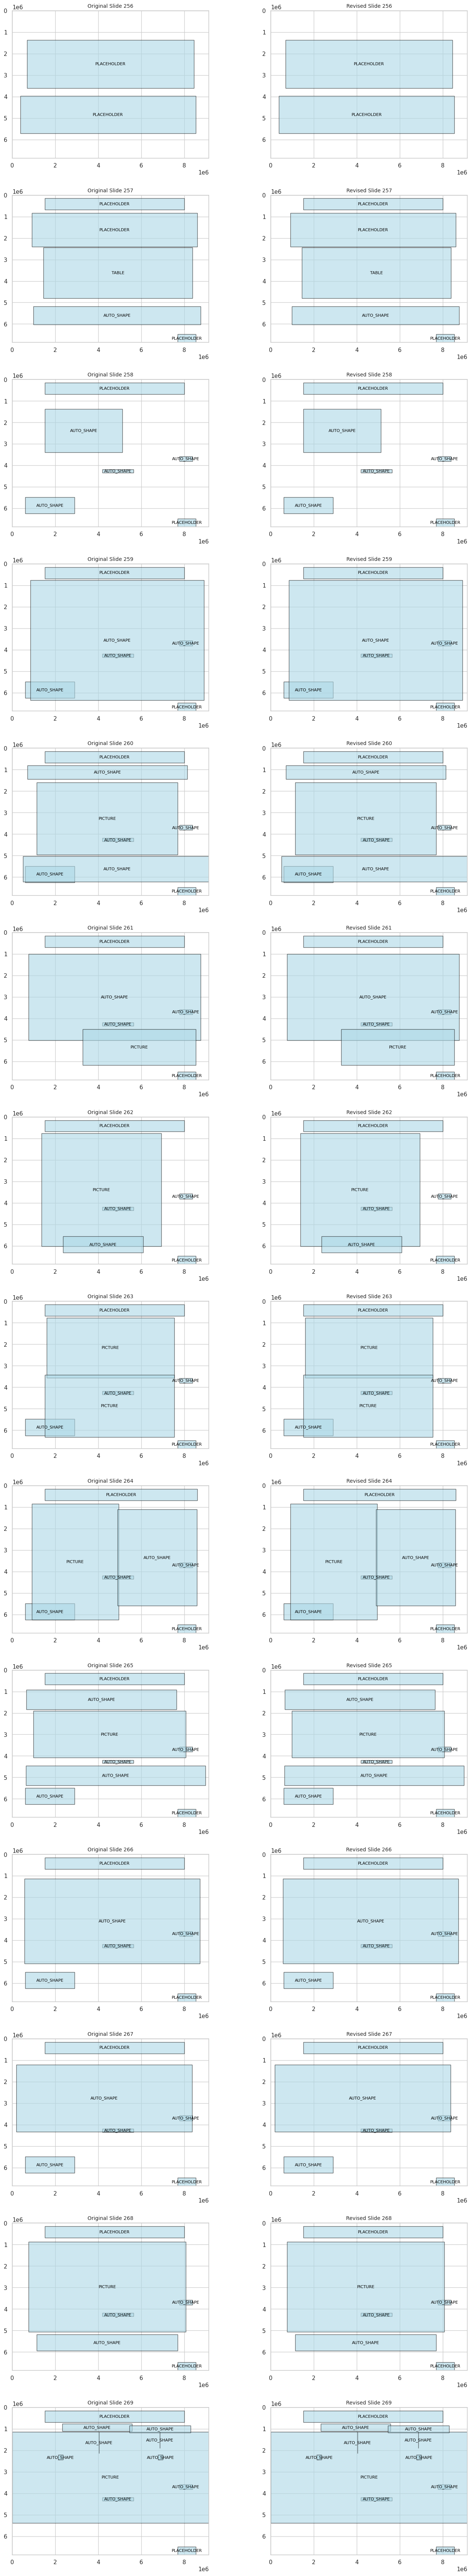

In [3]:
from pptlayout.visualizers.layout_visualizer import generate_comparison_grid

slides = info["slides"]
# Generate comparison grid
comparison_grid = generate_comparison_grid(
    slides,
    slides,
    slide_width=info["slide_width"],
    slide_height=info["slide_height"]
    )